# Infere with recommender system

In [1]:
# This ensures all modules are re-imported when import is called. This is useful for easier development and debugging.
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

## Load modules

In [3]:
# Import NumPy, pandas, matplotlib and PyTorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.set_option('display.max_rows', 500)



# Import sklearn modules
from sklearn.metrics.pairwise import cosine_similarity

# Import Utility Functions
import pickle
import json
import os
from tqdm import tqdm

# Import custom modules
from modelling.preprocessing import feature_engineering, get_bin_labels
from engine.utils import most_similar_index, calculateCriterion, calc_dh_tol
from crecsys import ZRMrecsys


In [4]:
df = pd.read_pickle("data/dataset.pkl")

## Calculate optimal dh_tol function


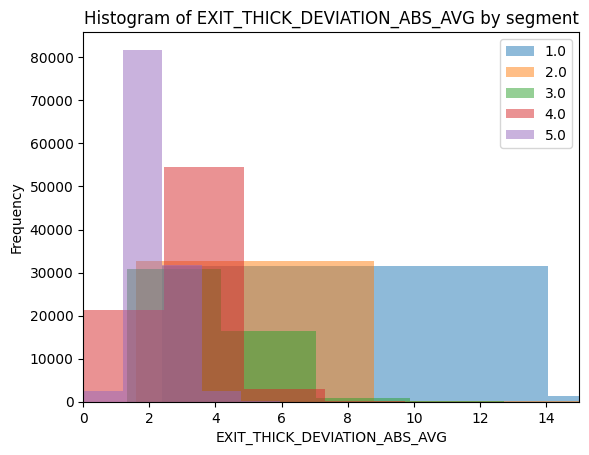

In [5]:
col = 'EXIT_THICK_DEVIATION_ABS_AVG'
grouped = df.groupby('pass_nr')

# plot histograms for each group on same plot
fig, ax = plt.subplots()
for name, group in grouped:
    ax.hist(group[col], bins=10, alpha=0.5, label=name)

# set plot properties
plt.legend()
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {} by segment'.format(col))
plt.xlim([0,15])

# show plot
plt.show()

y = -3.68691 * x + 0.37739 * x^2 + 11.37321


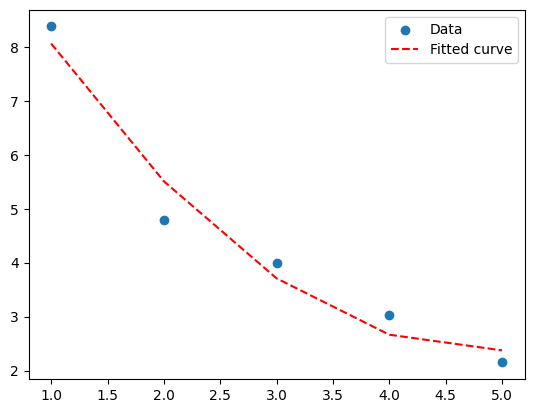

In [6]:
x = np.arange(1,6)
y = grouped[col].mean().values
from scipy.optimize import curve_fit

# define the true objective function
def objective(x, a, b, c):
 return a * x + b * x**2 + c

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
plt.scatter(x, y, label='Data')
x_line = np.arange(min(x), max(x+1), 1)
y_line = objective(x_line, a, b, c)
plt.plot(x_line, y_line, '--', color='red', label='Fitted curve')
plt.legend()
plt.show()

In [7]:
df_l = df.copy()
numeric_cols = df_l.select_dtypes(include='number').columns.values
df_l = df_l.groupby(['coil_id', 'pass_nr'])


# Define aggregation functions for different columns
agg_functions = {col: "median" for col in numeric_cols}
agg_functions['class'] = 'last'
agg_functions['coil_id'] = 'last'
# Apply aggregation functions to the grouped DataFrame
df_l = df_l.agg(agg_functions).reset_index(drop=True)

## Manual optimization

In [8]:
data = df_l.iloc[[2566]]

In [14]:
lambda1 = 0.6
pass_nr = int(data["pass_nr"].iloc[0])
dh_tol = calc_dh_tol(pass_nr, data['REF_INITIAL_THICKNESS'].iloc[0])
#print(pass_nr, dh_tol)
recsys_obj = ZRMrecsys()

coil_df = data.copy()

new_coil, new_coil_idx = recsys_obj.preprocess_coil_data(coil_df)
act_used = data.iloc[[0]][['tension_en', 'tension_ex', 'velocity_mdr']].copy()

act_used['pred'] = recsys_obj.predictQuality(act_used, new_coil, new_coil_idx)

res1 = recsys_obj.recommend(coil_df, pass_nr, dh_tol, lambda1)
#print(res1[0])
res2 = recsys_obj.optimize_1(coil_df, pass_nr, dh_tol, lambda1)
#print(res2)
res3 = recsys_obj.optimize_2(coil_df, pass_nr, dh_tol, lambda1)
#print(res3)

res = pd.concat([act_used, res1[0], res2, res3])
res['coil_id'] = int(coil_df['coil_id'].values[0])
res['pass_nr'] = pass_nr
res['class'] = coil_df['class'].values[0]
res['type'] = ['recipe', 'reccomender', 'opt1', 'opt2']
res['lambda1'] = lambda1
res['dh_tol'] = dh_tol

c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']
Finding similar of: ['010005']
Found similar: ['020005']


In [12]:
res

,tension_en,tension_ex,velocity_mdr,pred,coil_id,pass_nr,class,type,lambda1,dh_tol
2566,95.524366,119.507976,803.958710,1.929791,514,5,1,recipe,0.6,2.19179
0,92.480263,110.068320,625.465290,1.734647,514,5,1,reccomender,0.6,2.19179
0,73.769692,130.807000,356.491994,1.554390,514,5,1,opt1,0.6,2.19179
0,73.770000,100.860000,622.369947,1.744677,514,5,1,opt2,0.6,2.19179


## Auto optimization for all train data

In [ ]:
filename_save = 'recipe_analysis.csv'

In [ ]:

res_fin = pd.DataFrame()
for i in tqdm(range(df_l.shape[0])):

  try:
    coil_df = df_l.iloc[[i]]
    lambda1 = 0.5
    pass_nr = int(coil_df["pass_nr"].iloc[0])
    dh_tol = calc_dh_tol(pass_nr, coil_df['REF_INITIAL_THICKNESS'].iloc[0])
    #print(pass_nr, dh_tol)
    recsys_obj = ZRMrecsys()


    new_coil, new_coil_idx = recsys_obj.preprocess_coil_data(coil_df)
    act_used = coil_df.iloc[[0]][['tension_en', 'tension_ex', 'velocity_mdr']].copy()
    act_used['pred'] = recsys_obj.predictQuality(act_used, new_coil, new_coil_idx)

    res1 = recsys_obj.recommend(coil_df, pass_nr, dh_tol, lambda1)
    #print(res1[0])
    res2 = recsys_obj.optimize(coil_df, pass_nr, dh_tol, lambda1)
    #print(res2)
    res3 = recsys_obj.optimize_adv(coil_df, pass_nr, dh_tol, lambda1)
    #print(res3)

    res = pd.concat([act_used, res1[0], res2, res3])
    res['coil_id'] = int(coil_df['coil_id'].values[0])
    res['pass_nr'] = pass_nr
    res['grade'] = coil_df['class'].values[0]
    res['type'] = ['recipe', 'reccomender', 'opt1', 'opt2']
    res['lambda1'] = lambda1
    res['dh_tol'] = dh_tol
    # Write the header if it doesn't exist
    if not os.path.exists(filename_save):
        res.to_csv(filename_save, index=False)
    else:
      res.to_csv(filename_save, mode='a', index=False, header=False)
    # Write the data
    res_fin = pd.concat([res_fin, res])
  except:
    print("Something was wrong with index {}".format(i))
res_fin = res_fin.reset_index(drop=True)

In [ ]:
res_fin = pd.read_csv(filename_save, index=False)

In [ ]:
recipe_columns = ['tension_en',
                  'tension_ex',
                  'velocity_mdr']

In [ ]:
#grouped_recipe = res_fin.loc[( (res_fin['pass_nr'] == 4) & (res_fin['type'] == 'recipe'))].groupby('grade')
pass_nr = 1
num_intervals = 20  # Example number of intervals
grouped_recipe = res_fin.loc[( (res_fin['pass_nr'] == pass_nr) )].groupby('type')

colors = cm.gist_rainbow(np.linspace(0, 1, len(grouped_recipe)+1))

gen_animate = True

for j in range(len(grouped_recipe)+1):
  fig, ax = plt.subplots(1,3, figsize=(16, 9))
  for i, col in enumerate(recipe_columns):
    min_value = np.amin(grouped_recipe[col].min())
    max_value = np.amax(grouped_recipe[col].max())
    # Create intervals based on min and max values
    intervals = np.linspace(min_value, max_value, num_intervals + 1)

    for k, rcp in enumerate(grouped_recipe):
        name = rcp[0]
        group = rcp[1]
        if gen_animate:
          if k >= j:
            continue
        data = group[col]
        weights = np.ones_like(data)/float(len(data))
        hist_values, bin_edges = np.histogram(data, bins=intervals, weights=weights)
        ax[i].hist(data, weights=weights, bins=bin_edges, alpha=0.4, label=name, color=colors[k])
        ax[i].legend()
        ax[i].set_xlabel(col)
        ax[i].set_ylabel("Normalized frequency")
        ax[i].set_ylim([0,1])
    name = 'train'
    data = df.loc[( (df['pass_nr'] == pass_nr) )][col]
    weights = np.ones_like(data)/float(len(data))
    ax[i].hist(data, weights=weights, bins=intervals, alpha=0.4, label=name, color=colors[-1])
    ax[i].legend()
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Normalized")
    ax[i].set_ylim([0,1])
  plt.suptitle("Pass number:{}".format(pass_nr))
  #plt.savefig("img_mag/distribution_recipe_train_passnr"+str(pass_nr)+"_"+str(j)+".png")
  # show plot
  plt.show()